In [ ]:
!pip install mediapipe


In [ ]:
!pip install torch_geometric

In [ ]:
# ---  Upload Files ---
from google.colab import files
import zipfile
import os
import pandas as pd

# Upload ZIP
print("🗂️ Now upload the ZIP file of your image folder:")
uploaded_zip = files.upload()
zip_filename = next(iter(uploaded_zip))

# Extract ZIP to /content/images/
extract_dir = "/content/images"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Set image_folder path (assuming ZIP contains a folder with the same name)
subfolders = [f for f in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, f))]
print("📁 Subfoldres found:", subfolders)

# Assume the first one is your image folder
image_folder = os.path.join(extract_dir, subfolders[0])
print("✅ Using image folder:", image_folder)
print("✅ Image folder set to:", image_folder)

# --- [2] Install Dependencies ---
!pip install -q torch torchvision

# --- [3] Imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image


In [ ]:
# Upload CSV
print("📄 Please upload your cleaned CSV file:")
uploaded_csv = files.upload()
csv_path = next(iter(uploaded_csv))



In [ ]:
# Read CSV
df = pd.read_csv(csv_path)

# Build full image paths
image_paths = df['imagename'].apply(lambda x: os.path.join(image_folder, x)).tolist()
labels = df['label'].tolist()

print("✅ Found", len(image_paths), "images.")
print("Sample paths:", image_paths[:3])
print("Sample labels:", labels[:3])
print(len(image_paths))  
print(len(labels))        



In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torch_geometric.nn import GCNConv
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


In [ ]:

import os
import csv
import pickle
import mediapipe as mp
from PIL import Image
import numpy as np
from tqdm import tqdm

# ✅ Set this to your unzipped image root folder (you already confirmed this)
image_folder = "/content/images/combined_datasets_whole"

# ✅ Your CSV path (you uploaded this)
csv_path = "/content/cleaned_combined_static_images.csv"

# ------------------------------------------
# 🔍 Load image paths from CSV
image_paths = []
with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # skip header if present
    for row in reader:
        rel_path = row[0]  # assuming first column is image filename/path
        abs_path = os.path.join(image_folder, rel_path)
        if os.path.isfile(abs_path):
            image_paths.append(abs_path)
        else:
            print(f"⚠️ Missing file: {abs_path}")

print(f"🖼️ Total valid image files: {len(image_paths)}")

# ------------------------------------------
# 🧠 MediaPipe Landmark Extraction
face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
landmark_dict = {}

print("🔍 Extracting landmarks using MediaPipe...")
for path in tqdm(image_paths):
    try:
        img = Image.open(path).convert("RGB")
        img_np = np.array(img)
        results = face_mesh.process(img_np)
        if results.multi_face_landmarks:
            landmarks = [[lm.x, lm.y] for lm in results.multi_face_landmarks[0].landmark]
        else:
            landmarks = [[0.0, 0.0]] * 468
        landmark_dict[path] = landmarks
    except Exception as e:
        print(f"⚠️ Failed on {path}: {e}")
        landmark_dict[path] = [[0.0, 0.0]] * 468

# ------------------------------------------
# 💾 Save to pickle
with open("landmarks.pkl", "wb") as f:
    pickle.dump(landmark_dict, f)

print("✅ Done! Saved landmarks to: landmarks.pkl")


In [7]:
class MicroExpressionDataset(Dataset):
    def __init__(self, image_paths, labels, landmark_dict, train=True):
        self.image_paths = image_paths
        self.labels = labels
        self.landmark_dict = landmark_dict
        self.train = train

        if self.train:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.Resize((112, 112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((112, 112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        img_tensor = self.transform(img)

        landmarks = self.landmark_dict.get(img_path, [[0.0, 0.0]] * 468)
        landmarks = torch.tensor(landmarks, dtype=torch.float)

        return img_tensor, label, landmarks

    def __len__(self):
        return len(self.image_paths)



# ---------------- Pseudo-Sequence Reconstruction with Temporal Embedding ----------------
class PseudoSequenceReconstruction(nn.Module):
    def __init__(self, in_channels, steps=3):
        super().__init__()
        self.steps = steps
        self.encoder = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.decoder = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.temporal_embed = nn.Parameter(torch.randn(steps, in_channels, 1, 1))

    def forward(self, x):
        motion_frames = []
        for i in range(self.steps):
            noise = torch.randn_like(x) * 0.05
            motion = x + noise
            encoded = F.relu(self.encoder(motion))
            decoded = self.decoder(encoded)
            decoded = decoded + self.temporal_embed[i]
            motion_frames.append(decoded.unsqueeze(1))  # [B, 1, C, H, W]
        motion_tensor = torch.cat(motion_frames, dim=1)  # [B, T, C, H, W]
        return torch.mean(motion_tensor, dim=1)  # [B, C, H, W]

# ---------------- Attention Modules ----------------
class TripletAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = self.sigmoid(self.conv(x))
        return x * attn

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attn = self.sigmoid(self.conv(x_cat))
        return x * attn

# ---------------- Patch Embedding ----------------
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        return self.conv(x)

# ---------------- Transformer Block ----------------
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.ReLU(),
            nn.Linear(dim*2, dim)
        )

    def forward(self, x):
        x2 = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + x2
        return x + self.ff(self.norm2(x))

# ---------------- Graph Convolution Block ----------------
class GraphConvBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, in_channels)
        self.conv2 = GCNConv(in_channels, in_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# ---------------- Attention Pooling ----------------
class AttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x):
        weights = F.softmax(self.attn(x), dim=1)
        return torch.sum(weights * x, dim=1)

# ---------------- ROI Extraction ----------------
def extract_rois(feature_map, landmarks_batch, roi_size=48):
    B, C, H, W = feature_map.shape
    N = landmarks_batch.shape[1]
    patches = []
    for b in range(B):
        single_img_patches = []
        for lm in landmarks_batch[b]:
            y, x = int(lm[1] * H), int(lm[0] * W)
            top = max(0, y - roi_size // 2)
            left = max(0, x - roi_size // 2)
            bottom = min(H, top + roi_size)
            right = min(W, left + roi_size)
            patch = feature_map[b, :, top:bottom, left:right]
            pad_bottom = roi_size - patch.shape[1] if patch.shape[1] < roi_size else 0
            pad_right = roi_size - patch.shape[2] if patch.shape[2] < roi_size else 0
            patch = F.pad(patch, (0, pad_right, 0, pad_bottom), mode='constant', value=0)
            single_img_patches.append(patch.unsqueeze(0))
        single_img_patches = torch.cat(single_img_patches, dim=0)
        patches.append(single_img_patches.unsqueeze(0))
    return torch.cat(patches, dim=0)

# ---------------- Graph Edge Construction ----------------
def build_edge_index(num_nodes):
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return edge_index

# ---------------- ApexFormerNet ----------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch_geometric.nn import GCNConv

class ApexFormerNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # EfficientNet-B0 partial backbone
        base_efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(base_efficientnet.features[:6])
        self.feature_dim = 112

        # Projector to 128 channels
        self.projector = nn.Conv2d(self.feature_dim, 128, kernel_size=1)

        # PSR module
        self.psr = PseudoSequenceReconstruction(128)

        # Patch Embedding blocks
        self.patch_embed_16 = PatchEmbedding(128, 16)
        self.patch_embed_32 = PatchEmbedding(128, 32)
        self.patch_embed_48 = PatchEmbedding(128, 48)

        # Attention modules (after patch embedding, before transformer)
        self.triplet_attn = TripletAttention(128)
        self.spatial_attn = SpatialAttention()

        # Transformer layers
        self.transformer1 = TransformerBlock(128)
        self.transformer2 = TransformerBlock(128)

        # GCN + attention pooling
        self.graph_block = GraphConvBlock(128)
        self.attn_pool = AttentionPooling(128)

        # Classification head
        self.norm = nn.LayerNorm(128)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x, landmarks):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        B = x.size(0)

        # Backbone + Projector + PSR
        x = self.backbone(x)
        x = self.projector(x)
        x = self.psr(x)

        # ROI extraction
        roi_patches = extract_rois(x, landmarks, roi_size=48)  # [B, N, C, H, W]
        B, N, C, H, W = roi_patches.shape
        roi_patches = roi_patches.view(B * N, C, H, W)

        # Multi-scale patch embeddings
        patch16 = self.patch_embed_16(roi_patches)
        patch32 = self.patch_embed_32(roi_patches)
        patch48 = self.patch_embed_48(roi_patches)

        # Flatten and average across spatial dimensions
        patch16 = patch16.view(B * N, 128, -1).mean(dim=2)
        patch32 = patch32.view(B * N, 128, -1).mean(dim=2)
        patch48 = patch48.view(B * N, 128, -1).mean(dim=2)

        # Fuse multi-scale features
        fused = patch16 + patch32 + patch48  # [B*N, 128]

        # Apply attention AFTER patch fusion, BEFORE transformer
        fused = fused.view(B * N, 128, 1, 1)
        fused = self.triplet_attn(fused)
        fused = self.spatial_attn(fused)
        fused = fused.view(B * N, 128)

        # Prepare sequence for transformer
        patch_seq = fused.view(B * N, 1, 128)  # [B*N, T=1, 128]
        patch_seq = self.transformer1(patch_seq)
        patch_seq = self.transformer2(patch_seq)
        patch_seq = patch_seq.squeeze(1)  # [B*N, 128]

        # GCN on node features
        patch_seq = patch_seq.view(B, N, -1)  # [B, N, 128]
        edge_index = build_edge_index(N).to(x.device)
        patch_seq_flat = patch_seq.view(B * N, -1)
        patch_seq_flat = self.graph_block(patch_seq_flat, edge_index)
        patch_seq = patch_seq_flat.view(B, N, -1)

        # Attention pooling
        pooled = self.attn_pool(patch_seq)

        # Final head
        pooled = self.dropout(self.norm(pooled))
        logits = self.classifier(pooled)
        probs = F.softmax(logits, dim=-1)
        return probs


In [ ]:
#Path confirmation

df = pd.read_csv(csv_path)
print(f"📄 Total rows in CSV: {len(df)}")
print("📁 First 5 filenames from CSV:")
print(df.iloc[:5, 0])

print(f"📂 Image folder: {image_folder}")
print("📷 First 5 files in folder:")
print(os.listdir(image_folder)[:5])


In [ ]:
print("✅ image_paths:", len(image_paths))
print("✅ labels:", len(labels))

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import time
import pickle

# ✅ Load precomputed landmarks
with open("landmarks.pkl", "rb") as f:
    landmark_dict = pickle.load(f)

# ✅ Shuffle indices
indices = torch.randperm(len(image_paths)).tolist()

# ✅ Split sizes
train_size = int(0.6 * len(image_paths))
val_size = int(0.2 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

# ✅ Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# ✅ Slice data
train_paths = [image_paths[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]

val_paths = [image_paths[i] for i in val_indices]
val_labels = [labels[i] for i in val_indices]

test_paths = [image_paths[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]

# ✅ Datasets with precomputed landmarks
train_set = MicroExpressionDataset(train_paths, train_labels, landmark_dict, train=True)
val_set   = MicroExpressionDataset(val_paths, val_labels, landmark_dict, train=False)
test_set  = MicroExpressionDataset(test_paths, test_labels, landmark_dict, train=False)

# ✅ WeightedRandomSampler Setup (Step 2)
class_counts = [train_labels.count(0), train_labels.count(1), train_labels.count(2)]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in train_labels])
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# ✅ DataLoaders, you can try batch_size=4,8,16,32.... based on gpu access
train_loader = DataLoader(
    train_set,
    batch_size=16,
    sampler=sampler,         
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_set,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_set,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)




In [31]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
import copy

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, epochs=80, device='cuda'):
    model = model.to(device)

    # ✅ Print total trainable parameters
    num_params = count_parameters(model)
    print(f"\n🧮 Total Trainable Parameters: {num_params:,}")

    # ✅ CrossEntropyLoss with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

    # ✅ AdamW optimizer with weight decay
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # ✅ LR scheduler (ReduceLROnPlateau)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=2, factor=0.5, verbose=True
    )

    # ✅ Mixed precision
    scaler = GradScaler()

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"🔧 Training on: {device}")
    print(f"📦 Model on: {next(model.parameters()).device}")

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels, landmarks in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            landmarks = landmarks.to(device, non_blocking=True)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images, landmarks)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            del images, labels, landmarks, outputs, loss, predicted
            torch.cuda.empty_cache()

        train_acc = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # --- Validation ---
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels, landmarks in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                landmarks = landmarks.to(device, non_blocking=True)

                with autocast():
                    outputs = model(images, landmarks)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                del images, labels, landmarks, outputs, loss, predicted
                torch.cuda.empty_cache()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(avg_val_loss)

        print(f"🧠 Epoch {epoch + 1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print("💾 Best model updated!")

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [33]:
print(f"Train images: {len(train_set)}")
print(f"Validation images: {len(val_set)}")
print(f"Test images: {len(test_set)}")


Train images: 265
Validation images: 88
Test images: 89


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ApexFormerNet(num_classes=3).to(device)

# ✅ Store returned values
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, epochs=50, device=device
)


🧮 Total Trainable Parameters: 60,197,831
🔧 Training on: cuda
📦 Model on: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-31-2821655382.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-31-2821655382.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [25]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


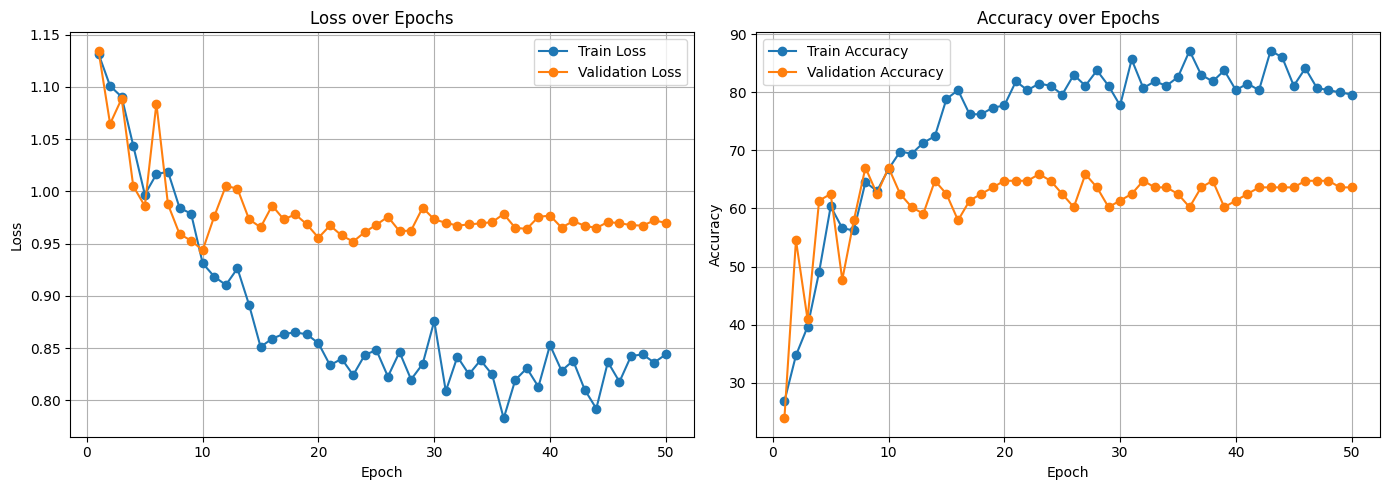

In [26]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, test_loader, device='cuda', class_names=None):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, landmarks in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            landmarks = landmarks.to(device)

            outputs = model(images, landmarks)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # --- Classification Report (Per Class) ---
    print("\n📊 Classification Report (Per Class):")
    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    for cls in class_names:
        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1 = report[cls]['f1-score']
        support = report[cls]['support']
        print(f"{cls:10} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f} | Support: {support}")

    # --- Overall Metrics ---
    acc = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100

    print(f"\n✅ Accuracy: {acc:.2f}%")
    print(f"🎯 Precision (Macro Avg): {precision:.2f}%")
    print(f"📈 Recall (Macro Avg): {recall:.2f}%")
    print(f"📉 F1 Score (Macro Avg): {f1:.2f}%")

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("\n📦 Confusion Matrix (Raw Values):")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --- Trainable Parameters ---
    num_params = count_parameters(model)
    print(f"\n🧮 Total Trainable Parameters: {num_params}")

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plotting Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()




In [ ]:
evaluate_model(model, val_loader, device=device, class_names=["Positive", "Negative", "Surprised"])
